# Librerías necesarias

In [ ]:
pip install qiskit

In [ ]:
pip install openqaoa

In [4]:
pip install cplex

Note: you may need to restart the kernel to use updated packages.


## Maximal independent set (MIS) con Qiskit

<br><center><img src="./mis_problem_.png" width="800"></center><br>


## QUBO

$$f(\mathrm{x}) = \mathrm{x}^T Q \mathrm{x}$$

$$\lambda\frac{1}{2}(1-z_i) (1-z_j) = \lambda\frac{1}{2} (1 - z_i - z_j + z_iz_j)$$

$$H(z) = \sum_i h_i z_i + \sum_{i,j} J_{ij} z_i z_j + \mathrm{offset}$$

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

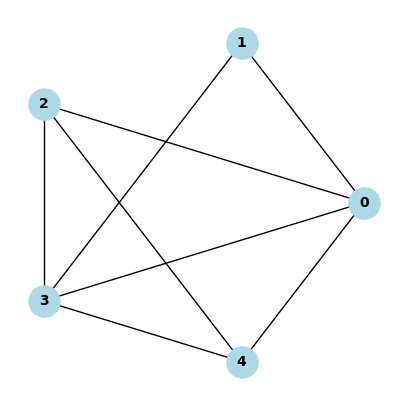

In [2]:
n_nodes = 5
edges = [[0,1], [0, 2], [0,3], [0, 4], [1,3], [2,3], [2,4], [3,4]]
G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edges)
pos = nx.circular_layout(G)

fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G, pos = pos, ax=ax, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')


In [3]:
def QUBO(G, lambd = 2):
    n_nodes = len(G.nodes)
    Q = np.zeros((n_nodes, n_nodes))
    for i in G.nodes:
        Q[i,i] = -1
    for i, j in G.edges:
        Q[i, j] = lambd
    return Q
        

In [4]:
def ising_hamiltonian(G, lambd=2):
    n_nodes = len(G.nodes)
    Jij = np.zeros((n_nodes, n_nodes))
    h = np.zeros((n_nodes))
    offset = 0
    for i in G.nodes:
        h[i] += 1/2
        offset -= 1/2
    for i, j in G.edges:
        Jij[i,j] += (1/4) * lambd
        h[i] -= (1/4) * lambd
        h[j] -= (1/4) * lambd
        offset += (1/4) * lambd
    return h, Jij, offset

In [5]:
Q = QUBO(G)
x = np.array([[0],[1],[0],[0],[1]])
Cost = x.T @ Q @ x
print(f"Cost QUBO: {Cost[0,0]}")

Cost QUBO: -2.0


In [6]:
h, Jij, offset = ising_hamiltonian(G)
z = np.array([[1],[-1],[1],[1],[-1]])
Cost = z.T @ Jij @ z + h @ z + offset
print(f"Cost Ising Hamiltonian: {Cost[0,0]}")

Cost Ising Hamiltonian: -2.0


## Quantum Circuit

In [7]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Operator


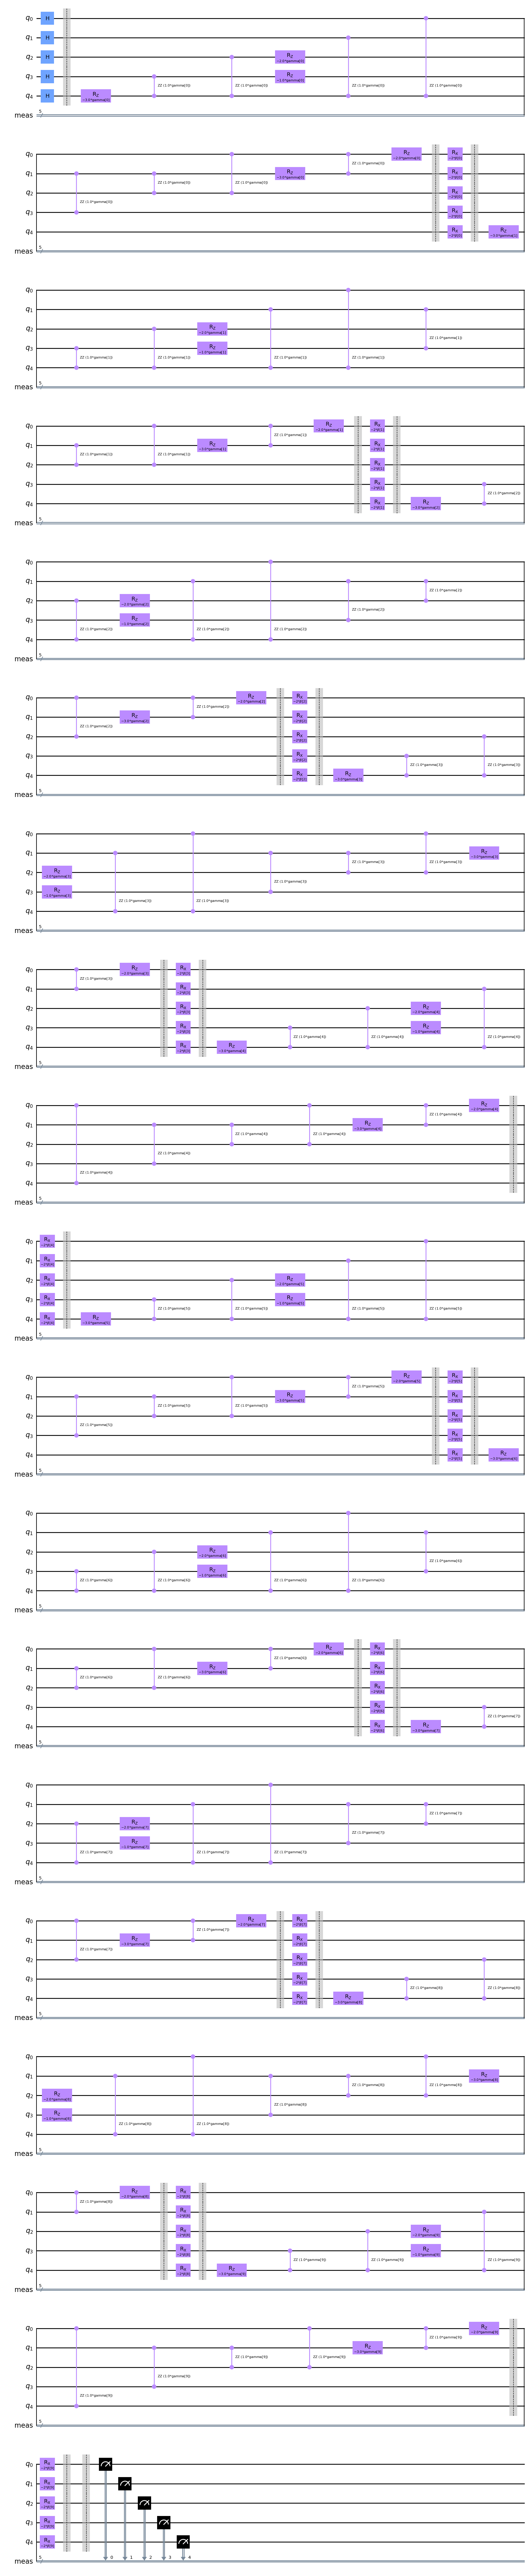

In [8]:
p = 10 #QAOA layers

beta = ParameterVector(r"$\beta$", p)
gamma = ParameterVector("gamma", p)
qaoa_circ = QuantumCircuit(n_nodes)
qaoa_circ.h(range(n_nodes))
qaoa_circ.barrier()
for pi in range(p):
    for i in range(n_nodes):
        if h[i] != 0:
            qaoa_circ.rz(2 * gamma[pi] * h[i], i)
        for j in range(i+1, n_nodes):
            if Jij[i,j] != 0:
                qaoa_circ.rzz(2 * gamma[pi] * Jij[i,j], i, j)
    qaoa_circ.barrier()
    qaoa_circ.rx(-2 * beta[pi], range(n_nodes))
    qaoa_circ.barrier()
qaoa_circ = qaoa_circ.reverse_bits()
qaoa_circ.measure_all()
qaoa_circ.draw("mpl")

## Transferencia de conocimiento 

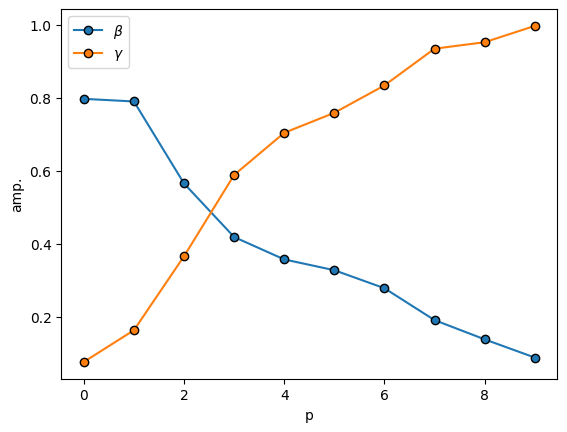

In [9]:
beta  = [0.7977, 0.7905, 0.5657, 0.4189, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765, 0.1634, 0.3662, 0.5890, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]

fig, ax = plt.subplots()
ax.plot(beta, label=r"$\beta$", marker="o", markeredgecolor="black")
ax.plot(gamma, label=r"$\gamma$", marker="o", markeredgecolor="black")
ax.set_xlabel("p")
ax.set_ylabel("amp.")
ax.legend()

## Correr en Simulador

In [10]:
backend = Aer.get_backend("qasm_simulator")
new_circ = transpile(qaoa_circ.assign_parameters(beta+gamma))
results = backend.run(new_circ, shots=1000).result().get_counts()

In [ ]:
backend = Aer.get_backend("qasm_simulator")
new_circ = transpile(qaoa_circ.assign_parameters(beta+gamma))
results = backend.run(new_circ, shots=1000).result().get_counts()

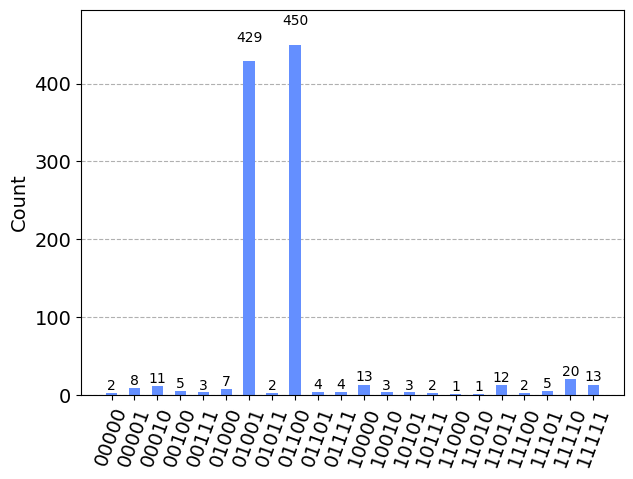

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(results)

## Correr en dispositivo real

In [ ]:
pip install qiskit_ibm_provider

In [46]:
from qiskit_ibm_provider import IBMProvider

In [47]:
provider = IBMProvider()
ibm_brisbane = provider.get_backend("ibm_brisbane")

In [ ]:
new_circ = transpile(qaoa_circ.assign_parameters(beta+gamma), backend=ibm_brisbane)
results = ibm_brisbane.run(new_circ, shots=1000).result().get_counts()

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(results)

# Usando OpenQAOA

In [17]:
from openqaoa import QAOA
from openqaoa.problems.converters import FromDocplex2IsingModel
from docplex.mp.model import Model


In [18]:
mdl = Model("MIS")
x = mdl.binary_var_list(G.nodes, name="x")
cost = mdl.sum(-x[i] for i in G.nodes)
for i, j in G.edges:
    cost += 2 * x[i] * x[j]
mdl.minimize(cost)
mdl.solve() # Solving the problem
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MIS
// var contrainer section
dvar bool x[5];

minimize
 - x_0 - x_1 - x_2 - x_3 - x_4 [ 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 + 2 x_0*x_4
 + 2 x_1*x_3 + 2 x_2*x_3 + 2 x_2*x_4 + 2 x_3*x_4 ];
 
subject to {

}


In [19]:
print(mdl.solution)
print(mdl.get_solve_details())
print(mdl.get_solve_status())

solution for: MIS
objective: -2
x_1=1
x_2=1

status  = integer optimal solution
time    = 0.033484 s.
problem = MIQP
gap     = 0%

JobSolveStatus.OPTIMAL_SOLUTION


In [20]:
qubo = FromDocplex2IsingModel(mdl)
ising = qubo.ising_model
print({tuple(k):v for k, v in zip(ising.terms, ising.weights)})

{(0, 1): 0.5, (0, 2): 0.5, (0, 3): 0.5, (0, 4): 0.5, (1, 3): 0.5, (2, 3): 0.5, (2, 4): 0.5, (3, 4): 0.5, (0,): -1.5, (1,): -0.5, (2,): -1.0, (3,): -1.5, (4,): -1.0}


In [21]:
qaoa = QAOA()
params = {"betas":beta, "gammas":gamma}
qaoa.set_circuit_properties(p=p, init_type="custom", variational_params_dict=params)
qaoa.set_classical_optimizer(maxiter=1) 
qaoa.compile(ising)
qaoa.optimize()
results = qaoa.result.lowest_cost_bitstrings(1000)
print(results)

{'solutions_bitstrings': ['01001', '01100', '01101', '10000', '01000', '00100', '00001', '00010', '10001', '00011', '00110', '00000', '00101', '10010', '10100', '11000', '01010', '01011', '01110', '11100', '11001', '10011', '10110', '11010', '10101', '00111', '11101', '01111', '11110', '11011', '10111', '11111'], 'bitstrings_energies': [-2.0, -2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 6.0, 6.0, 8.0, 11.0], 'probabilities': [0.43920592212124315, 0.43920592212124315, 0.003055415315987778, 0.012345480552950617, 0.010198096481959205, 0.007408429657970366, 0.007408429657970366, 0.012345480552950617, 8.893970399964424e-05, 8.893970399964424e-05, 8.893970399964424e-05, 0.005053497593979785, 0.0006259286569974962, 0.0017292944119930826, 8.893970399964424e-05, 0.0005838727559976645, 0.0005838727559976645, 0.0003489182389986043, 0.0003489182389986043, 0.0003489182389986043, 0.0003489182389986043, 0

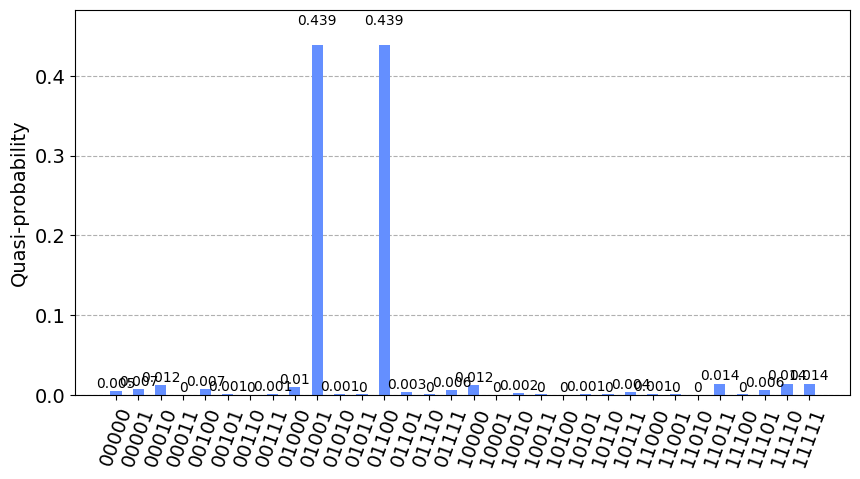

In [22]:
solutions = {k:v for k, v in zip(results["solutions_bitstrings"],results["probabilities"])}
fig, ax = plt.subplots(figsize=(10,5))
plot_histogram(solutions, ax=ax)

## Otros problemas en OpenQAOA

In [23]:
from openqaoa.problems import TSP_LP

In [24]:
tsp = TSP_LP.random_instance(n_nodes=5, method="unbalanced", subtours=[])
ising = tsp.qubo

In [40]:
qaoa = QAOA()
params = {"betas":beta, "gammas":gamma}
qaoa.set_circuit_properties(p=p, init_type="custom", variational_params_dict=params)
qaoa.set_classical_optimizer(maxiter=1) 
qaoa.compile(ising)
qaoa.optimize()

results = qaoa.result.lowest_cost_bitstrings(25)


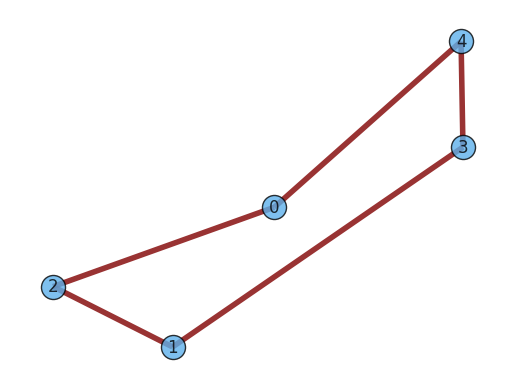

In [41]:
opt_sol = results["solutions_bitstrings"][0]
fig, ax = plt.subplots()
tsp.plot_solution(opt_sol, ax=ax)

In [43]:
results["probabilities"]

[0.001731675076022513,
 0.006084917001079109,
 0.0021048059050273638,
 0.004702088297061131,
 0.000512121553006658,
 0.0006918579740089947,
 0.0008180194790106349,
 0.001150320973014955,
 0.00036686246800476946,
 8.62337120011211e-05,
 0.0013015072530169205,
 0.00011897641400154678,
 0.0037080944560482078,
 0.002746848550035711,
 0.004769810146062011,
 0.0017508973250227628,
 0.0003602264010046832,
 0.00032870899900427344,
 0.0006761901640087909,
 0.0007579834760098543,
 9.805046100127472e-05,
 0.0005202729570067639,
 0.0003014236260039187,
 0.001688971378021958,
 8.564216400111341e-05]

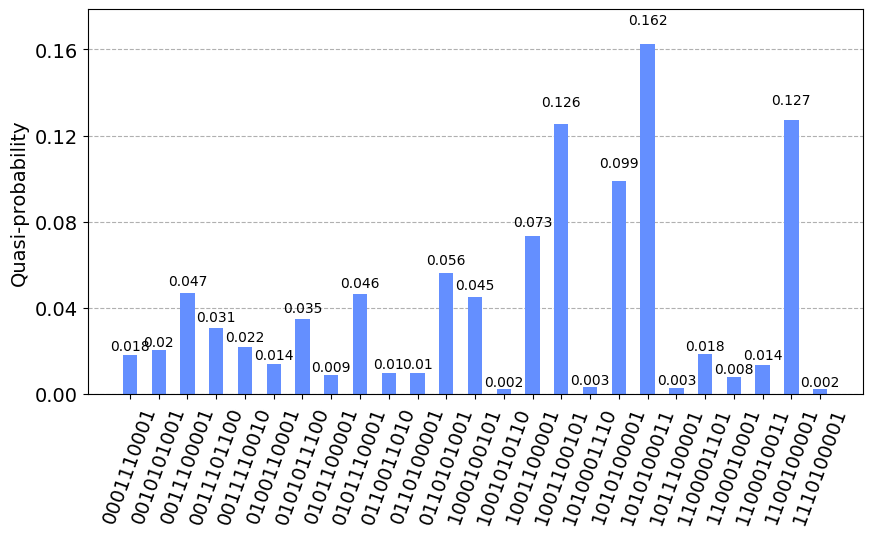

In [42]:
solutions = {k:v for k, v in zip(results["solutions_bitstrings"],results["probabilities"])}
fig, ax = plt.subplots(figsize=(10,5))
plot_histogram(solutions, ax=ax)